In [1]:
from data_pipeline import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from clustering import *
import seaborn as sns
import scipy.stats as stats
from syntren import *
from gnw import *

In [6]:
root_gene = None
minimum_evidence = 'weak'
max_depth = np.inf
r_expr, gene_symbols, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)

# Split data into train and test sets
train_idxs, test_idxs = split_train_test(sample_names)
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]
nb_train, nb_genes = expr_train.shape

### GAN data ###
synthetic_name = 'EColi_n{}_r{}_e{}_d{}'.format(len(gene_symbols), root_gene, minimum_evidence, max_depth)
gan_expr, gs = load_synthetic(synthetic_name)
assert (np.array(gene_symbols) == np.array(gs)).all()

Found 4297 genes in datafile


# Intensity histograms

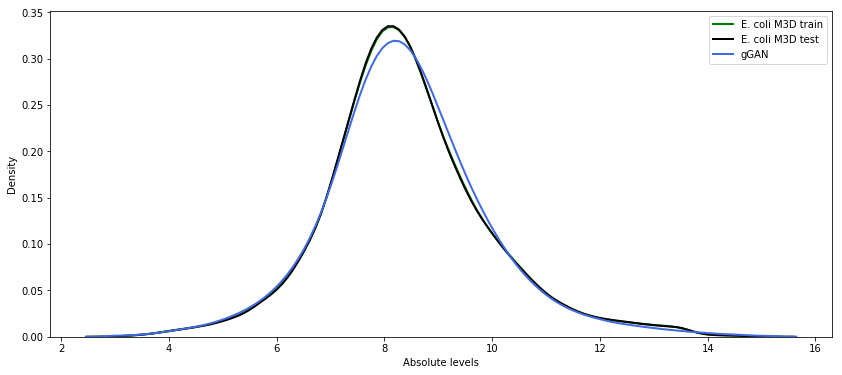

In [30]:
plt.figure(figsize=(14, 6))
ax = plot_intensities(expr_train, dataset_name='E. coli M3D train', color='green', plot_quantiles=False)
ax = plot_intensities(expr_test, dataset_name='E. coli M3D test', color='black', plot_quantiles=False)
ax = plot_intensities(gan_expr, dataset_name='gGAN', color='royalblue', plot_quantiles=False, ax=ax);

# Gene ranges histograms

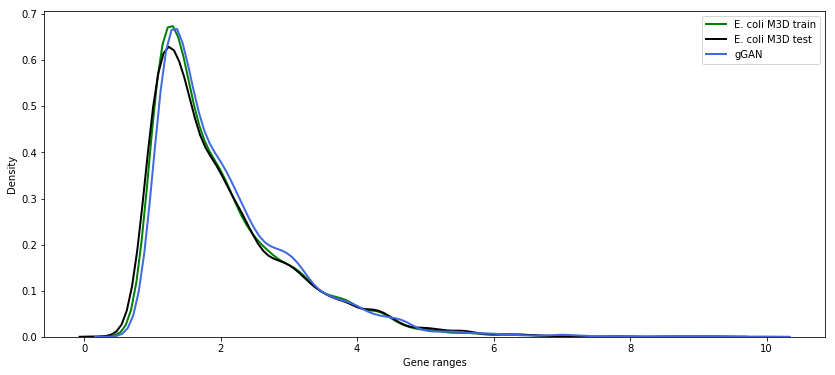

In [31]:
plt.figure(figsize=(14, 6))
ax = plot_gene_ranges(expr_train, dataset_name='E. coli M3D train', color='green')
ax = plot_gene_ranges(expr_test, dataset_name='E. coli M3D test', color='black')
plot_gene_ranges(gan_expr, dataset_name='gGAN', color='royalblue', ax=ax);

# TF-TG histogram (using synthetic background distribution)

In [32]:
train_tf_tg_corr, train_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols)
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_test, gene_symbols)
gan_tf_tg_corr, gan_tg_tg_corr = compute_tf_tg_corrs(gan_expr, gene_symbols)
train_back_corr = correlations_list(expr_train, expr_train)
r_back_corr = correlations_list(expr_test, expr_test)
gan_back_corr = correlations_list(gan_expr, gan_expr)

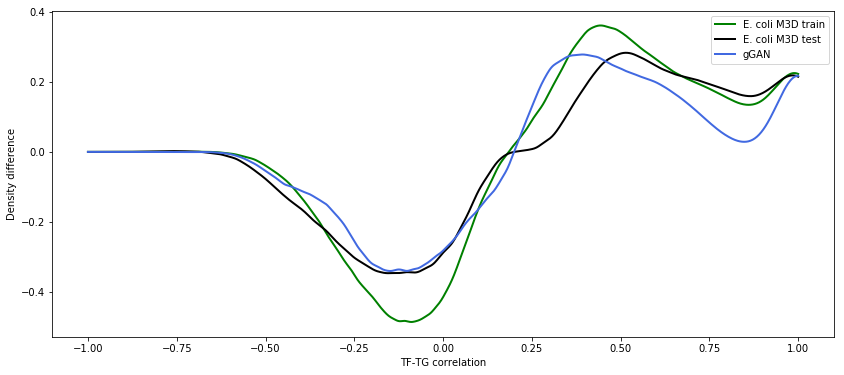

In [33]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(train_tf_tg_corr, train_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D train', color='green')
ax = plot_difference_histogram(r_tf_tg_corr, r_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D test', color='black')
plot_difference_histogram(gan_tf_tg_corr, gan_back_corr, 'TF-TG correlation', dataset_name='gGAN', color='royalblue', ax=ax); 

# TG-TG histogram (using synthetic background distribution)

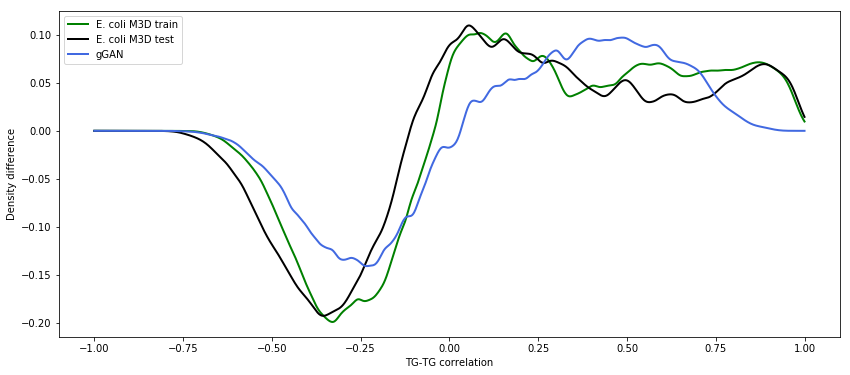

In [34]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(train_tg_tg_corr, train_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D train', color='green')
ax = plot_difference_histogram(r_tg_tg_corr, r_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D test', color='black', ax=ax)
ax = plot_difference_histogram(gan_tg_tg_corr, gan_back_corr, 'TG-TG correlation', dataset_name='gGAN', color='royalblue', ax=ax);

# Compare background distributions

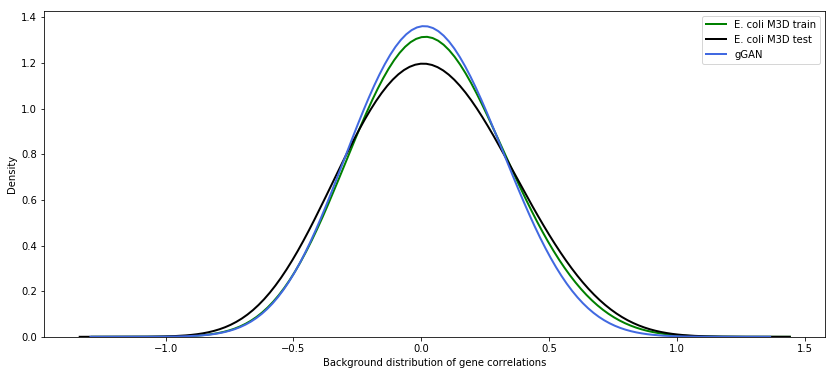

In [35]:
plt.figure(figsize=(14, 6))
ax = plot_distribution(train_back_corr, label='E. coli M3D train', color='green')
ax = plot_distribution(r_back_corr, label='E. coli M3D test', color='black')
ax = plot_distribution(gan_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='gGAN', color='royalblue');

# TF activity histogram

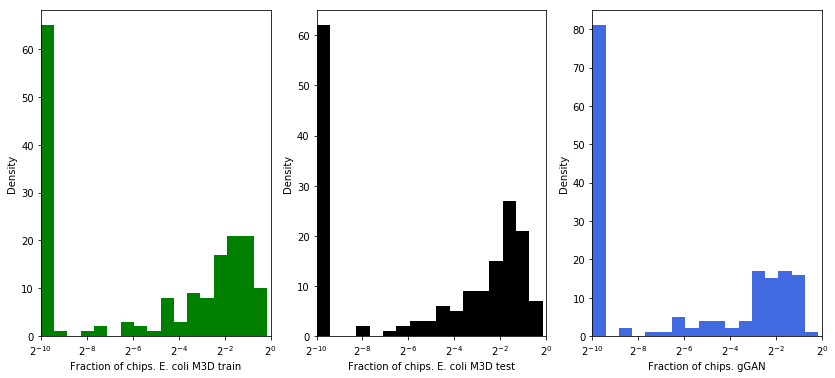

In [36]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plot_tf_activity_histogram(expr_train, gene_symbols, xlabel='Fraction of chips. E. coli M3D train', color='green')
plt.subplot(132)
plot_tf_activity_histogram(expr_test, gene_symbols, xlabel='Fraction of chips. E. coli M3D test', color='black')
plt.subplot(133)
plot_tf_activity_histogram(gan_expr, gene_symbols, xlabel='Fraction of chips. gGAN', color='royalblue');

# Quantitative analysis

In [3]:
scores = compute_scores(expr_test, gan_expr, gene_symbols)
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

scores = compute_scores(expr_test, expr_train, gene_symbols)
print('\nReal')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

gGAN
S_dist: 0.7826204015180681
S_dend: 0.28656266468321656
S_sdcc: 1.810886868071044e-06
S_tftg: 0.8133015241027692
S_tgtg: 0.8566482924917768
S_tfac: 0.9273232918605943

Real
S_dist: 0.9252001130527209
S_dend: 0.3565119286119809
S_sdcc: 0.0008152527855979566
S_tftg: 0.9228562561627353
S_tgtg: 0.9515038350566738
S_tfac: 0.9799788104815824


# Analyze gene histograms

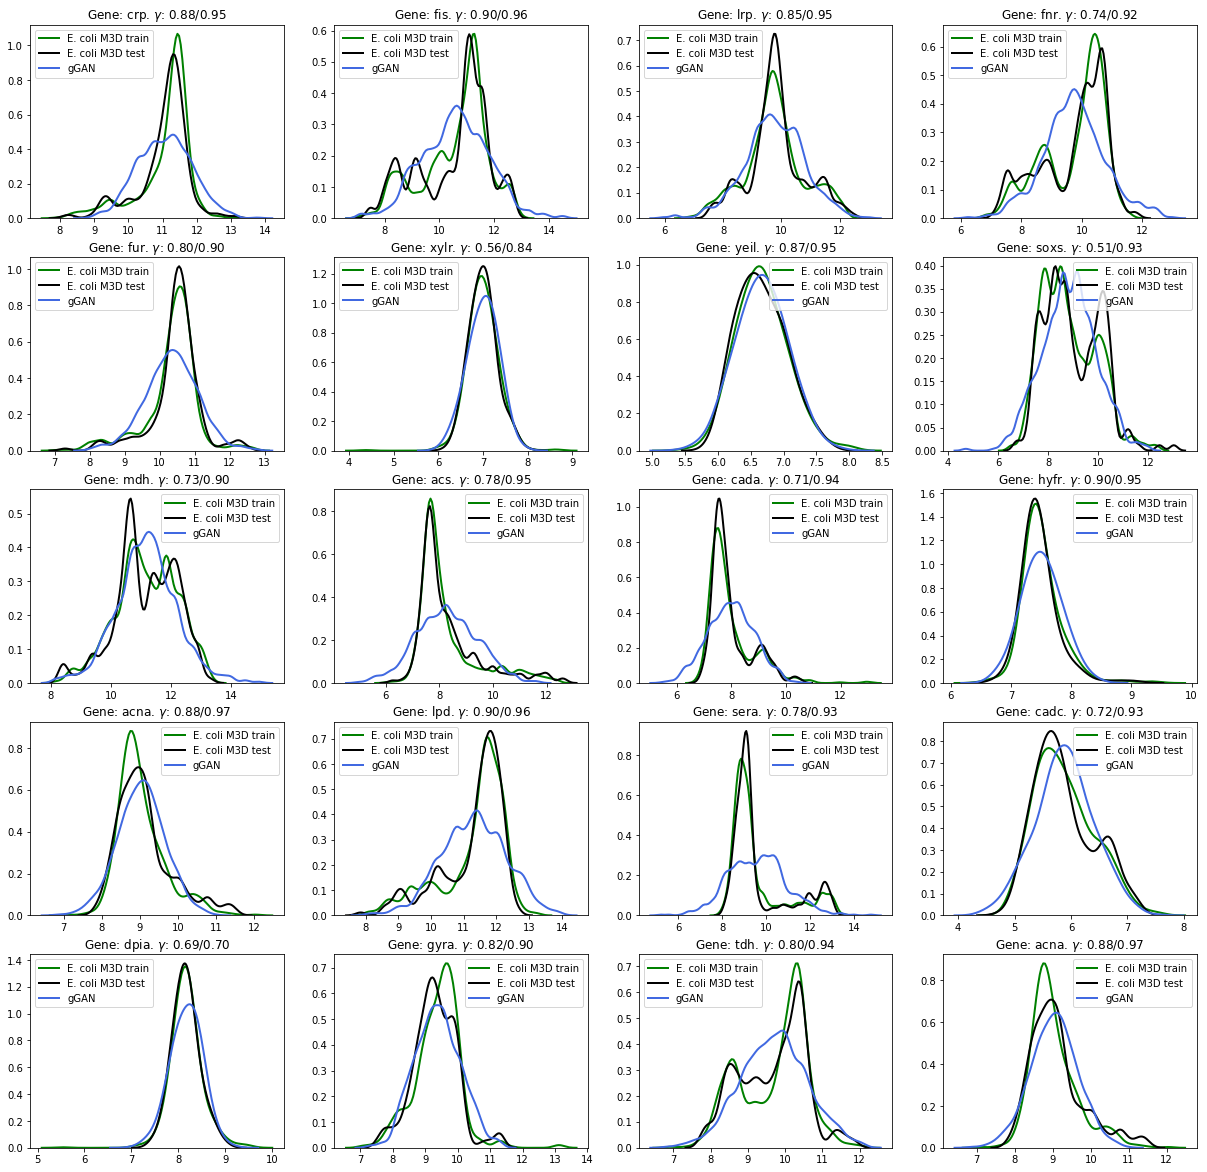

In [117]:
gene_list = ['crp', 'fis', 'lrp', 'fnr', # master regulators  'arca',
             'fur', 'xylr', 'yeil', 'soxs',
             'mdh', 'acs', 'cada', 'hyfr',
             'acna', 'lpd', 'sera', 'cadc',
             'dpia', 'gyra', 'tdh', 'acna']
nrows = 5
ncols = 4
assert nrows*ncols == len(gene_list)

dists_test = 1 - pearson_correlation(expr_test, expr_test)
dists_train = 1 - pearson_correlation(expr_train, expr_train)
dists_gan = 1 - pearson_correlation(gan_expr, gan_expr)

plt.figure(figsize=(18, 12))
plt.subplots_adjust(left=0, bottom=0, right=None, top=1.3, wspace=None, hspace=None)
for r in range(nrows):
    for c in range(ncols):
        idx = (nrows-1)*r + c
        plt.subplot(nrows, ncols, idx+1)
        idx = np.argwhere(np.array(gene_symbols) == gene_list[idx]).ravel()[0]
        
        gamma_dgan_dtest = pearson_correlation(dists_test[:, idx], dists_gan[:, idx])
        gamma_dtrain_dtest = pearson_correlation(dists_test[:, idx], dists_train[:, idx])
        plt.title('Gene: {}. $\gamma$: {:.2f}/{:.2f}'.format(gene_symbols[idx], gamma_dgan_dtest, gamma_dtrain_dtest))
        plot_distribution(expr_train[:, idx], xlabel='', ylabel='', label='E. coli M3D train', color='green');
        plot_distribution(expr_test[:, idx], xlabel='', ylabel='', label='E. coli M3D test', color='black');
        plot_distribution(gan_expr[:, idx], xlabel='', ylabel='', label='gGAN', color='royalblue');

# Select CRP hierarchy + quantitative analysis

In [7]:
root_gene = 'CRP'
minimum_evidence = 'weak'
max_depth = np.inf
r_expr_crp, gene_symbols_crp, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)
gene_symbols_all = np.array(gene_symbols)

# CRP hierarchy indices
idxs = np.array([np.where(gene_symbols_all == gs)[0] for gs in gene_symbols_crp]).ravel()

# Select expressions of genes in CRP hierarchy
select_expressions = lambda expr: expr[:, idxs]
expr_train_crp = select_expressions(expr_train)
expr_test_crp = select_expressions(expr_test)
gan_expr_crp = select_expressions(gan_expr)

Found 4297 genes in datafile
Found 1208 genes in CRP regulatory network
4297 genes not in gene subset. Selecting 1076 genes ...


In [8]:
scores = compute_scores(expr_test_crp, gan_expr_crp, gene_symbols_crp)
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

gGAN
S_dist: 0.7592787514141093
S_dend: 0.40199911506520913
S_sdcc: 0.00143253570228341
S_tftg: 0.8073035446588627
S_tgtg: 0.852829633901328
S_tfac: 0.91754872671738
